In [66]:
import numpy as np
import sklearn
import tensorflow as tf
import keras
import requests
import base64

 ### Defining the URLs needed to communicate with Strava API
 I first need to get my access token because it expires after a while. To do that I have a refresh token that never expires, I make a post request to the API and it sends back my acces token.

In [67]:
# All needed parameters to get my token, available on my Strava account
oauthUrl = 'https://www.strava.com/api/v3/oauth/token?'
refresh_token = 'e5c7b025d8b3841489b9a741eb03ceed94b075af'
access_token = ''
client_id = 73837
client_secret = '77f492b5ca6be20b52e95eb20def21a86a9de867'
grant_type = 'refresh_token'
postUrl = oauthUrl+'client_id='+str(client_id)+'&client_secret='+client_secret+'&code=3b29576c209a78b3d93affcfc1f8d4511f9e970a'+'&grant_type='+grant_type+'&refresh_token='+refresh_token

# Get the oauth token
headers = {'Authorization': 'Bearer {}'.format(access_token), 'Content-Type': 'application/json'}
search_api_url = 'https://api.yelp.com/v3/businesses/search'
params = {}
response = requests.post(postUrl, headers=headers, params=params, timeout=5)
dict = response.json()
access_token = dict['access_token']
dict

{'token_type': 'Bearer',
 'access_token': 'd062bbe918736891e95540fe42a56598680aef0e',
 'expires_at': 1642622241,
 'expires_in': 18769,
 'refresh_token': 'e5c7b025d8b3841489b9a741eb03ceed94b075af'}

### Getting all my activities to create a dataset
Now that I have my token, I can easily make calls to the API and get my Strava data.

In [68]:
activitiesUrl = 'https://www.strava.com/api/v3/athlete/activities?per_page=200'
getUrl = activitiesUrl + '&access_token=' + access_token
response = requests.get(getUrl, headers=headers, params=params, timeout=5)
activities = response.json()
getUrl

'https://www.strava.com/api/v3/athlete/activities?per_page=200&access_token=d062bbe918736891e95540fe42a56598680aef0e'

### Filtering unwanted activities
I will only work with my running data so I first filter every other activities.

In [69]:
running_activities = []

for activity in activities:
    if activity['type'] == 'Run':
        if 'average_heartrate' in activity:
            running_activities.append(activity)
len(running_activities)
running_activities[9]

{'resource_state': 2,
 'athlete': {'id': 17048501, 'resource_state': 1},
 'name': 'EF 65’',
 'distance': 13154.8,
 'moving_time': 3851,
 'elapsed_time': 3856,
 'total_elevation_gain': 84.0,
 'type': 'Run',
 'workout_type': 0,
 'id': 6512831380,
 'external_id': 'garmin_push_8106025296',
 'upload_id': 6925034673,
 'start_date': '2022-01-12T16:09:32Z',
 'start_date_local': '2022-01-12T17:09:32Z',
 'timezone': '(GMT+01:00) Europe/Paris',
 'utc_offset': 3600.0,
 'location_city': None,
 'location_state': None,
 'location_country': 'France',
 'achievement_count': 5,
 'kudos_count': 23,
 'comment_count': 0,
 'athlete_count': 2,
 'photo_count': 0,
 'map': {'id': 'a6512831380',
  'summary_polyline': 'gavdH|b~HB^R^VLzAa@h@BNEjCgAt@Tf@CHNXfAJNjA_@BBh@~BLhAPt@JHn@M`BcAf@Of@_@b@LtCyAtA[xFqCF?TT~BhL`@fCr@bDNlA~@lF@f@Px@Vl@XA\\T@X?`CB\\R`AFx@@fMCvB@dCDfBC~BJhEUhBQj@MPIpAa@dCa@bD@PUtC@jCYnF@jFJdDE|@NvF?pCb@VX@dAOfAYXShGqAlASP@hAYnC}@h@JRxBVn@TRJODa@VO|@OtCaBn@UnA}@hCiAb@KBBLb@`@~BjAlJVhDHlCClAIjAc@fCm@

### Creating a dataframe to extract the differents variable of each activity

In [70]:
import pandas as pd

features = ['distance', 'moving_time', 'elapsed_time', 'total_elevation_gain', 'elev_high', 'elev_low', 'average_cadence', 'average_temp', 'average_heartrate', 'max_heartrate', 'average_speed', 'max_speed', 'kudos_count', 'workout_type']

df = pd.json_normalize(running_activities)
df = df[features]
for i in range(len(df['workout_type'])):
    if pd.isna(df['workout_type'][i]):
        df['workout_type'][i] = 0


C:\Users\bapti\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


### Using sklearn I will use a kmeans clustering algorithm to plot the differents activities
At first I split the data between train and test datasets

In [71]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df.values)

train.shape

(110, 14)

In [72]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit_predict(test, y=None, sample_weight=None)

array([3, 3, 2, 0, 3, 1, 3, 2, 2, 1, 0, 3, 2, 2, 1, 3, 1, 1, 3, 3, 1, 2,
       2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 3, 3, 2, 3])

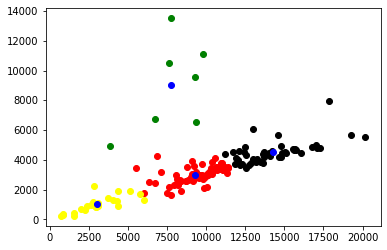

,distance,moving_time,elapsed_time,total_elevation_gain,elev_high,elev_low,average_cadence,average_temp,average_heartrate,max_heartrate,average_speed,max_speed,kudos_count,workout_type
0,9798.3,2696,2706,64.0,50.6,24.4,89.3,18,142.3,155.0,3.634,4.690,11,0.0
3,8382.2,1900,1906,115.0,54.2,41.4,89.7,18,184.4,191.0,4.398,5.758,49,1.0
5,8196.5,2332,2340,50.0,52.0,26.4,87.5,18,141.8,174.0,3.515,6.232,17,0.0
6,11353.0,3117,3360,73.0,85.2,33.6,89.0,19,140.1,153.0,3.642,5.557,21,0.0
7,9632.1,3002,3106,61.0,60.6,32.0,88.0,16,127.7,149.0,3.209,4.152,23,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,9119.2,3056,3184,117.0,234.0,185.8,84.7,28,132.6,153.0,2.984,4.200,14,0.0
141,8849.3,2642,2700,145.0,287.0,195.0,86.9,29,148.0,159.0,3.349,4.700,11,0.0
143,9364.4,3186,3333,38.0,238.2,229.0,81.1,30,156.4,189.0,2.939,7.000,16,0.0
144,8159.8,2744,2855,152.0,275.0,178.2,84.1,30,134.0,156.0,2.974,4.000,14,0.0


In [73]:
import matplotlib.pyplot as plt

label = kmeans.fit_predict(df)
 
#filter rows of original data
label0 = df[label == 0]
label1 = df[label == 1]
label2 = df[label == 2]
label3 = df[label == 3]

#plotting the results
cols = label0.columns
centers = pd.DataFrame(kmeans.cluster_centers_, columns=features)


plt.scatter(label0[cols[0]], label0[cols[1]], color = 'red')
plt.scatter(label1[cols[0]], label1[cols[1]], color = 'black')
plt.scatter(label2[cols[0]], label2[cols[1]], color = 'green')
plt.scatter(label3[cols[0]], label3[cols[1]], color = 'yellow')
plt.scatter(centers[cols[0]], centers[cols[1]], color='blue')

plt.show()
label0

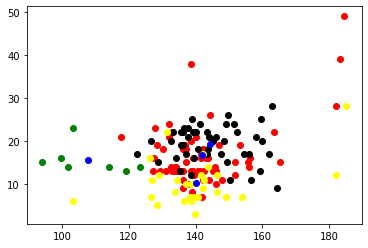

In [74]:
plt.scatter(label0[cols[8]], label0[cols[12]], color = 'red')
plt.scatter(label1[cols[8]], label1[cols[12]], color = 'black')
plt.scatter(label2[cols[8]], label2[cols[12]], color = 'green')
plt.scatter(label3[cols[8]], label3[cols[12]], color = 'yellow')
plt.scatter(centers[cols[8]], centers[cols[12]], color='blue')

plt.show()

### PCA Analysis before Kmeans

In [75]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

x = StandardScaler().fit_transform(df)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf


,principal component 1,principal component 2
0,-1.231168,-0.794942
1,-0.000307,3.658980
2,-1.200163,-1.665992
3,-2.736689,3.268940
4,-0.858689,-2.322269
...,...,...
142,4.160575,1.726599
143,-0.445146,0.512107
144,0.123782,-1.832568
145,-0.746779,-0.801753


array([0.38752077, 0.25213321])

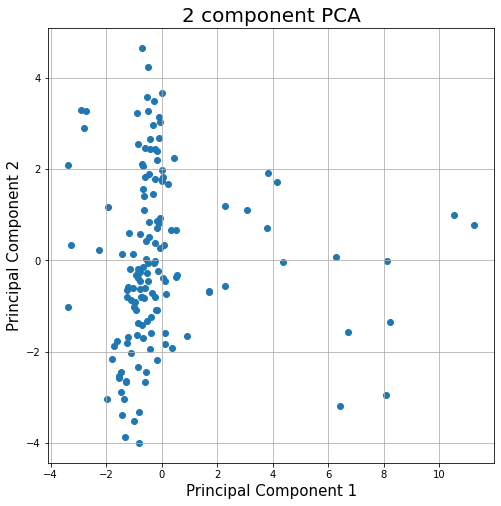

In [76]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
'''targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)'''
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'])
ax.grid()
pca.explained_variance_ratio_

### New approach with a SVM

In [80]:
from sklearn import svm
train, test = train_test_split(df.values)
Xtrain = train[:, :12]
Ytrain = np.array(train[:,13], dtype='int')
Xtest = test[:, :12]
Ytest = np.array(test[:,13], dtype='int')

clf = svm.SVC()
clf.fit(Xtrain, Ytrain)

clf.predict(Xtest)
clf.class_weight_


array([1., 1., 1., 1.])

https://www.strava.com/api/v3/athlete/zones?per_page=200&access_token=d062bbe918736891e95540fe42a56598680aef0e


'd062bbe918736891e95540fe42a56598680aef0e'